In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'


In [2]:
%load_ext autoreload
%autoreload 2

In [23]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import seaborn as sns
from torchvision import datasets as datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

from model_resnet import ResNet18, ResNet50



In [4]:
class Args:
    batch_size = 256
    train_batch_size = 5000
    lr = 1e-2
    gamma = 0.95
    log_interval = 100
    epochs = 20

args = Args()



In [5]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainset, _ = train_test_split(trainset, train_size=5_000)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testset, _ = train_test_split(testset, train_size=2_000)

train_loader = DataLoader(trainset, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=args.train_batch_size)


In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pooling = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.pooling = nn.MaxPool2d(4)
        self.dropout1 = nn.Dropout(0.1)
        self.fc1 = nn.Linear(64*49, 128)
        self.dropout2 = nn.Dropout(0.05)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = self.pooling(x)
        x = F.elu(self.conv4(x))
        x = F.elu(self.conv4(x))

        x = torch.flatten(x, 1)
        x = self.dropout1(x)
        x = F.elu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



In [7]:
# model = Net()
model = ResNet50()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.Adadelta(model.parameters(), lr=args.lr)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=args.gamma)
for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/5000 (0%)]	Loss: 2.536922

Test set: Average loss: 1.7194, Accuracy: 1435/2000 (72%)

Train Epoch: 2 [0/5000 (0%)]	Loss: 0.529614

Test set: Average loss: 0.2224, Accuracy: 1867/2000 (93%)

Train Epoch: 3 [0/5000 (0%)]	Loss: 0.264147

Test set: Average loss: 0.1691, Accuracy: 1886/2000 (94%)

Train Epoch: 4 [0/5000 (0%)]	Loss: 0.205086

Test set: Average loss: 0.1558, Accuracy: 1907/2000 (95%)

Train Epoch: 5 [0/5000 (0%)]	Loss: 0.120156

Test set: Average loss: 0.1463, Accuracy: 1907/2000 (95%)

Train Epoch: 6 [0/5000 (0%)]	Loss: 0.120791

Test set: Average loss: 0.1313, Accuracy: 1921/2000 (96%)

Train Epoch: 7 [0/5000 (0%)]	Loss: 0.081820

Test set: Average loss: 0.1259, Accuracy: 1922/2000 (96%)

Train Epoch: 8 [0/5000 (0%)]	Loss: 0.074521

Test set: Average loss: 0.1229, Accuracy: 1923/2000 (96%)

Train Epoch: 9 [0/5000 (0%)]	Loss: 0.054889

Test set: Average loss: 0.1154, Accuracy: 1930/2000 (96%)

Train Epoch: 10 [0/5000 (0%)]	Loss: 0.076915

Test set: Average 

In [8]:
predictions = []
labels = []
probs = []
with torch.no_grad():
    for x_batch, y_batch in  test_loader:
        logits = model(x_batch.cuda())
        probs.append(torch.max(torch.softmax(logits, dim=-1), dim=-1).values.cpu().numpy())
        predictions.append(torch.argmax(logits, dim=-1).cpu().numpy())
        labels.append(y_batch.numpy())
labels = np.concatenate(labels)
predictions = np.concatenate(predictions, axis=-1)
probs = np.concatenate(probs, axis=-1)


In [9]:
errors = labels != predictions


In [10]:
uq = 1 - probs


In [11]:
T = 200

# model.train()
model.eval()
predictions = []
for t in range(T):
    if (t+1) % 10  == 0:
        print(t)
    probs = []
    for x_batch, y_batch in  test_loader:
        with torch.no_grad():
            logits = model(x_batch.cuda(), dropout_mask=True)
        probs.append(torch.softmax(logits, dim=-1).cpu().numpy())
    predictions.append(np.concatenate(probs, axis=0))


9
19
29
39
49
59
69
79
89
99
109
119
129
139
149
159
169
179
189
199


In [12]:
predictions = np.array(predictions)
predictions.shape


(200, 2000, 10)

In [41]:
def entropy(preds):
    return -np.mean((np.sum(np.log(preds) * preds, axis=-1)), axis=0)

def std_uq(preds):
    return np.std(np.max(preds, axis=-1), axis=0)

def bald(preds):
    means = np.mean(preds, axis=0)
    return - np.sum(np.log(means) * means, axis=-1) + entropy(preds)

def max_with_std(preds):
    stds = np.std(preds, axis=0)
    means = np.mean(preds, axis=0)
    mean_std = means - stds
    return 1 - np.max(mean_std, axis=-1)



acquisition = max_with_std
uq_mc = acquisition(predictions)
uq_mc_2 = entropy(predictions)

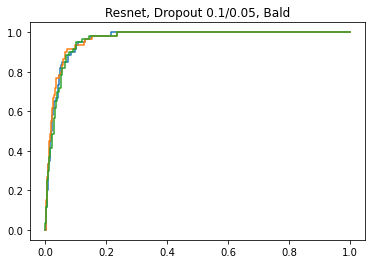

In [42]:
fpr, tpr, _ = roc_curve(errors, uq)
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(errors, uq_mc)
plt.plot(fpr, tpr)
plt.title("Resnet, Dropout 0.1/0.05, Bald")

fpr, tpr, _ = roc_curve(errors, uq_mc_2)
plt.plot(fpr, tpr)

195.10204081632654


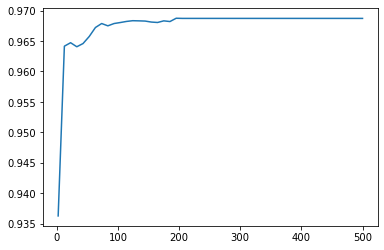

In [36]:
aucs = []
nums =  np.linspace(2, 500, 50)
max_score = 0
for num in nums:
    uq_sub = acquisition(predictions[:int(num)])
    score = roc_auc_score(errors, uq_sub)
    if score > max_score:
        i = num
        max_score = score
    aucs.append(score)
plt.plot(nums, aucs)
print(i)

In [16]:

stds = np.std(predictions, axis=0)
means = np.mean(predictions, axis=0)


<Figure size 720x576 with 0 Axes>

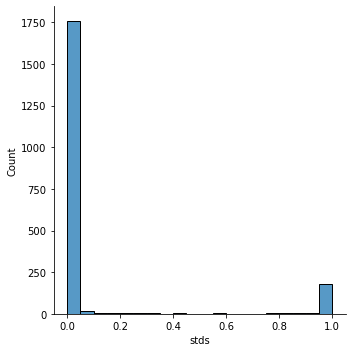

In [31]:
df = pd.DataFrame({'errors':errors, 'stds': stds[:, 0]})
plt.figure(figsize=(10, 8))
sns.displot(df, x='stds', bins=20)


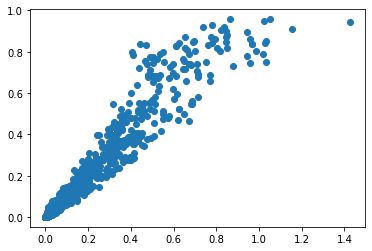

In [40]:
uq_1 = entropy(predictions)
uq_2 = max_with_std(predictions)
plt.scatter(uq_1, uq_2)

In [39]:
stds = np.std(predictions, axis=0)
means = np.mean(predictions, axis=0)
mean_std = means - stds
args_1 = np.argmax(means, axis=-1)
args_2 = np.argmax(mean_std, axis=-1)
np.sum(args_1 != args_2)

0